# Bézier Curves: Gerometric Interpretation
## De Casteljau's Algorithm: Theory, Implementation and Complexity Analysis

Paul de Casteljau developed the algorithm at Citroën as a a recursive method for evaluating Bézier curves. The method provides an intuitive **geometric construction**, where the curve is defined by successive interpolations between control points. Unlike polynomial-based approaches, De Casteljau's algorithm relies solely on **linear interpolation (lerp)**, making it numerically stable and robust.

Given a set of control points $ P_0, P_1, \dots, P_n $, the Bézier curve is defined parametrically by a recursive interpolation process:

1. At each step, new intermediate points are computed by performing linear interpolation between adjacent points from the previous step.
2. The interpolation follows the equation:

   $$
   P_i^{(k)}(t) = (1 - t) P_i^{(k-1)} + t P_{i+1}^{(k-1)}
   $$

   where:
   - $ P_i^{(0)} $ are the original control points.
   - $ P_i^{(r)} $ are the intermediate points at recursion depth $ r $.
   - $ t $ is the curve parameter, ranging from 0 to 1.

3. This process continues until only one point remains, which is the evaluated point on the Bézier curve for the given $ t $.




##### Python Helpers

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, Play, jslink, HBox, VBox

import time

# Enable inline plotting
%matplotlib inline

# Linear interpolation (lerp) function
def lerp(p0, p1, t):
    """Perform linear interpolation between points p0 and p1 using parameter t."""
    return (1 - t) * np.array(p0) + t * np.array(p1)

# De Casteljau's algorithm using only lerp
def de_casteljau(points, t):
    """
    Computes the point on the Bézier curve at parameter t by recursively applying lerp.
    
    Parameters:
      points: List of control points (each a tuple or list of coordinates)
      t: Parameter value in [0, 1]
    
    Returns:
      point: The computed point on the Bézier curve at t.
      levels: A list of lists, where each inner list contains the intermediate points at that recursion level.
    """
    points = [np.array(p) for p in points]
    levels = [points]  # level 0: the original control points
    while len(points) > 1:
        points = [lerp(points[i], points[i + 1], t) for i in range(len(points) - 1)]
        levels.append(points)
    return points[0], levels

### Geometric Construction

The following cell creates an interactive animation of the De Casteljau algorithm using a slider to vary the parameter **t**. In addition, a **Play** widget is linked to the slider so that the animation runs automatically.

The animation shows:

- The **control polygon** (dashed line connecting the control points).
- The **intermediate levels** of linear interpolated points (each in a different color).
- The final computed point on the Bézier curve for the given t.

##### Python Helpers

In [2]:
def plot_de_casteljau(t):
    """
    Plots the control polygon, intermediate levels, and the Bézier curve traced from t=0 to t.
    """
    colors = ['red', 'green', 'blue', 'orange', 'black']
    cp = np.array(control_points)
    # Compute current point and intermediate levels for t
    point, levels = de_casteljau(control_points, t)
    
    plt.figure(figsize=(15, 10))
    
    # Plot the control polygon
    #plt.plot(cp[:, 0], cp[:, 1], 'k--', label='Control Polygon')
    plt.plot(cp[:, 0], cp[:, 1], 'ko')
    
    # Plot each intermediate level
    for i, level in enumerate(levels[:-1]):  # skip the final level (single point)
        pts = np.array(level)
        plt.plot(pts[:, 0], pts[:, 1], 'o-', color=colors[i % len(colors)], label=f'Recursion Level {i+1}')
    
    # Trace the curve from t=0 to the current t
    if t > 0:
        t_values = np.linspace(0, t, 100)
        curve_points = np.array([de_casteljau(control_points, ti)[0] for ti in t_values])
        plt.plot(curve_points[:, 0], curve_points[:, 1], 'k-', linewidth=2, label='Traced Curve')
    
    # Highlight the final computed point on the curve
    plt.plot(point[0], point[1], 'ko', markersize=10, label=f'Curve Point t={t:.2f}')
    
    plt.title("De Casteljau's Algorithm: Geometric Construction")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

##### Run the following code to get an animated view

In [3]:
# Define control points and additional variables for the animation
control_points = [(0, 0), (1, 2), (3, 3), (4, 0)]

# Create a FloatSlider widget for t
t_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01, description='t')

# Create a Play widget to animate t (0 to 100 corresponds to t from 0 to 1)
play = widgets.Play(value=0, min=0, max=100, step=1, description="Press play", interval=100)

# Link the Play widget to the slider using an observer with a simple transform.
def update_slider(change):
    t_slider.value = change['new'] / 100

play.observe(update_slider, names='value')

# Display the Play widget and slider side by side.
display(HBox([play]))

# Create the interactive plot: as the slider moves, plot_de_casteljau is updated.
interact(plot_de_casteljau, t=t_slider);


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## 3. Complexity Analysis

The computational complexity of De Casteljau’s algorithm can be analyzed as follows:

- For **n control points**, the algorithm requires computing **n-1 interpolations** at each recursion level.
- The total number of interpolations performed follows a triangular sum:

  $$
  \sum_{r=1}^{n-1} r = \frac{(n-1) n}{2}
  $$

- Therefore, the **time complexity is $ O(n^2) $**, meaning that as the number of control points increases, the computation time grows quadratically. More precisely, the computational complexity is  **$ O(d n^2) $** where d is the number of dimensions.



This quadratic complexity is evident in the generated plot (below), where computation time increases non-linearly as control points increase.

###### Python Helpers

In [4]:
def measure_de_casteljau_time(n, t=0.5, trials=10):
    """
    Measures the average computation time of the de_casteljau algorithm for n control points.
    
    Parameters:
      n: Number of control points.
      t: Parameter for the algorithm.
      trials: Number of runs to average over.
    
    Returns:
      Average computation time in seconds.
    """
    total_time = 0.0
    for _ in range(trials):
        # Generate n random 2D control points.
        control_points = [np.random.rand(2) for _ in range(n)]
        start_time = time.perf_counter()
        de_casteljau(control_points, t)
        end_time = time.perf_counter()
        total_time += (end_time - start_time)
    return total_time / trials


def measure_curve_time(n, discretization=100, trials=100):
    """
    Measures the average computation time to compute a full Bézier curve 
    (evaluated at a specified number of discretization points) for a curve 
    defined by n control points.
    
    Parameters:
      n: Number of control points.
      discretization: Number of points along the curve (t values).
      trials: Number of trials for averaging.
    
    Returns:
      Average computation time (in seconds) for computing the full curve.
    """
    total_time = 0.0
    for _ in range(trials):
        control_points = [np.random.rand(2) for _ in range(n)]
        t_values = np.linspace(0, 1, discretization)
        start_time = time.perf_counter()
        for t in t_values:
            de_casteljau(control_points, t)
        end_time = time.perf_counter()
        total_time += (end_time - start_time)
    return total_time / trials

def plot_computation_time(max_points=50, t=0.5, trials=100):
    """
    Plots the average computation time of De Casteljau's algorithm vs. the number of control points,
    with computation time converted to milliseconds (dividing seconds by 1000).
    
    Parameters:
      max_points: Maximum number of control points to test (starting from 2).
      t: Parameter for the algorithm.
      trials: Number of runs per test for averaging.
    """
    num_points = list(range(2, max_points + 1))
    # Collect times as a list and convert to a numpy array for element-wise operations.
    times = np.array([measure_de_casteljau_time(n, t, trials) for n in num_points])
    
    plt.figure(figsize=(10, 6))
    plt.plot(num_points, times * 1000, marker='o')  # times in milliseconds
    plt.xlabel('Number of Control Points')
    plt.ylabel('Average Computation Time (ms)')
    plt.title("De Casteljau's Algorithm Computation Time vs. Number of Control Points")
    plt.grid(True)
    plt.show()

def plot_computation_time_points(discretization_range, cps_values, trials):
    # Dictionary to store computation times (in milliseconds)
    results = {}
    
    for cps in cps_values:
        times = []
        for d in discretization_range:
            avg_time = measure_curve_time(cps, discretization=d, trials=10)
            times.append(avg_time * 1000)  # convert seconds to milliseconds
        results[cps] = times
    
    # Plot the results: x-axis is the number of discretization points; one curve per control point count
    plt.figure(figsize=(10, 6))
    for cps in cps_values:
        plt.plot(list(discretization_range), results[cps], marker='o', label=f'{cps} control points')
    plt.xlabel('Number of Discretization Points')
    plt.ylabel('Average Computation Time (milliseconds)')
    plt.title('Computation Time vs. Discretization Points (per Bézier Curve)')
    plt.grid(True)
    plt.legend()
    plt.show()

##### Plot the computation time
The `plot_computation_time` function takes the following input:

- max_points: Maximum number of control points to test (starting from 2).
- t: Parameter for the algorithm.
- trials: Number of runs per test for averaging.

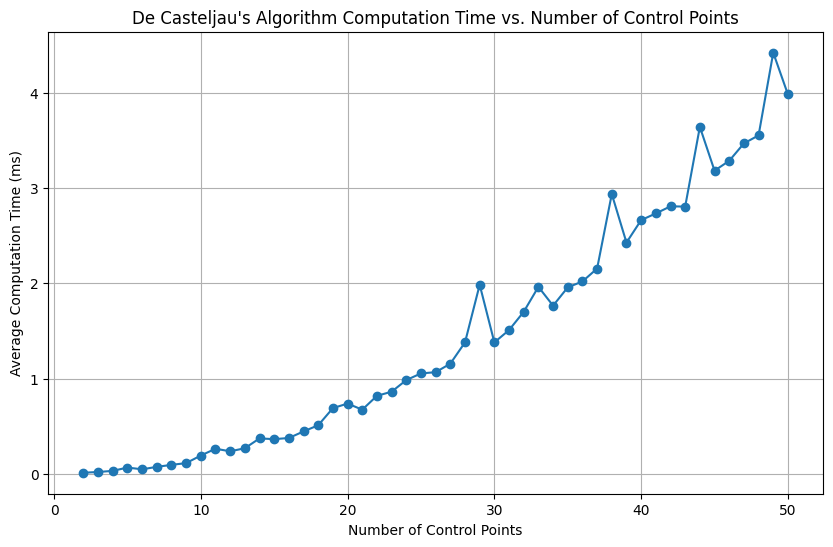

In [5]:
# Run the function to display the plot.
plot_computation_time(max_points=50, t=0.5, trials=100)

It also depends on the number of discretization points (the point on the curve I want to cumpute, it affect visualization performance)

The `plot_computation_time` function takes the following input:

- max_points: Maximum number of control points to test (starting from 2).
- t: Parameter for the algorithm.
- trials: Number of runs per test for averaging.

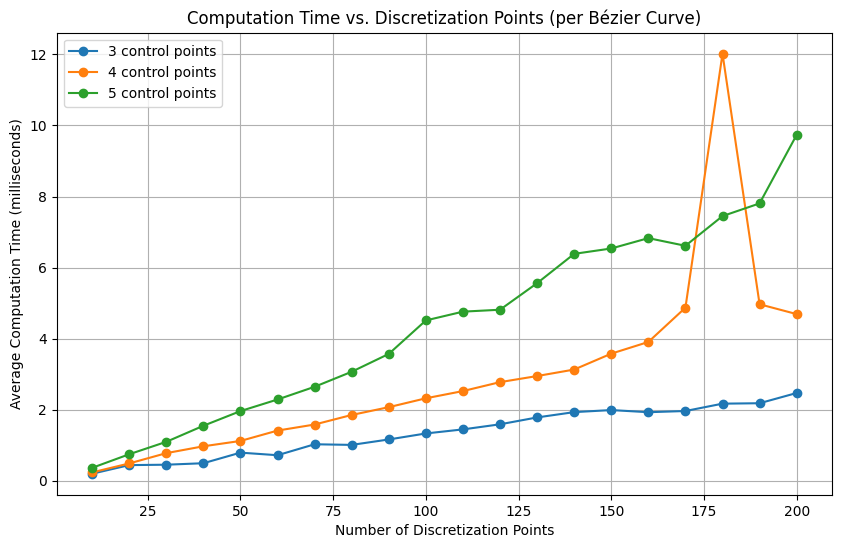

In [6]:
# Define a range for the number of discretization points
discretization_range = range(10, 201, 10)  # 10, 20, ... 200

# Define the control point counts to test
cps_values = [3, 4, 5]

plot_computation_time_points(discretization_range, cps_values, trials= 100)


De Casteljau’s algorithm **quadratic complexity** can become a bottleneck for high-degree curves. 

## The Bernstein Form of a Bézier Curve

De Casteljau’s algorithm is an elegant method for evaluating Bézier curves, relying **exclusively on linear interpolation** for numerical stability. However, Bézier approached curves from a different perspective, highlighting the need for an *explicit* representation of the curve. In other words, expressing a Bézier curve through a non-recursive mathematical formula—rather than an iterative algorithm—is essential. This explicit representation not only significantly facilitates further theoretical developments but also enables more efficient implementations.

Specifically, any point on a curve segment must be given by a parametric function of the following form:

$$
    P(t) = \sum_{i=0}^{n} P_i f_{i}(t)
$$

Where $P_{i}$ are the vectors of the $n+1$ vertices of the control polygon.

Then, Bézier set forth the properties that the $f_{i}(t)$ basis function must have and look for specific functions that meet these requirements. The requirements were:

- The functions must interpolate the first ($P_0$) and the last ($P_n$) vertex points.
- The $r-th$ derivative at an endpoint must be determined by its $r$ neighboring vertices. Thus, the tangent (first derivative) at $P_0$ must be given by $P_1 - P_0$ and the tangent at $P_n$ by $P_n - P_{n-1}$. This give the user the control of the tangent on the curve at each end. The second derivative at $P_0$ must bedetermined by $P_0, P_1$ and $P_2$, and so on.
- The functions $f_{i}(t)$ must be symmetric w.r.t. $t$ and $t-1$. This means that we can revers the sequence of the vertex points defining the curve without changing the shape of the curve.

Bézier chose a family of functions called *Bernstein Polynomials*. Bernstein polynomials are a family of polynomials that play an important role in approximation theory and computational mathematics. They are particularly famous for their use in Bézier curves in computer graphics and geometric modeling.

$$
  B_{n,i}(t) = \binom{n}{i} t^n (1-t)^{n-i}
$$

The Binomial coefficient is defined as follow:

$$
  \binom{n}{i} = \frac{n!}{i!(n-i)!}
$$